In [40]:
# set up:
%matplotlib inline
import random
import matplotlib.pylab as plt

from PIL import Image
import numpy as np
from scipy.misc import imresize
import glob

import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
import pickle
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Flatten, merge, Input
from keras import backend as K
import tensorflow as tf
from sklearn.metrics import roc_auc_score

In [41]:
# Load data
x = pickle.load( open( "cnn_data/train_data.pkl", "rb" ) )
y = pickle.load( open( "cnn_data/train_label.pkl", "rb" ) )
print('Number of data points:', len(x))

Number of data points: 5054


In [42]:
# Resize data so input has fixed size
size = 224  # all images will have size 224x224x3
X = []
for img in x:
    resized = imresize(img, (size, size,3))            
        
    X.append(resized)
X_train = np.array(X)
y_train = np.array(y)
print('Shape of data:', X_train.shape)
print('Shape of labels:', y_train.shape)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


Shape of data: (5054, 224, 224, 3)
Shape of labels: (5054,)


# Visualize some data

[0 2 0 0 0 0 0 0 1 0]


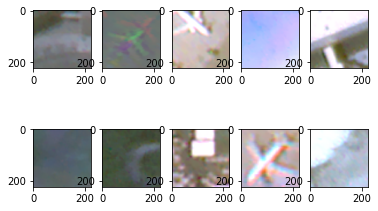

In [43]:
# display some random training images
img_idx = np.random.randint(0, X_train.shape[0], 10)
for i, img in enumerate(X_train[img_idx,:,:,:]):
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
print(y_train[img_idx])

(array([4150.,    0.,    0.,    0.,    0.,  779.,    0.,    0.,    0.,
         125.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

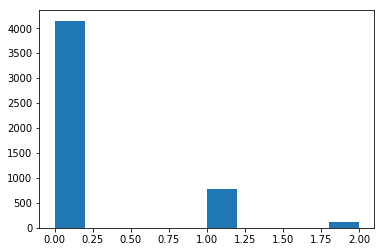

In [44]:
# CLasses in training data
plt.hist(y_train)

# Build model


I retrained only the last layer of VGG16 on the training set. Some features about the training that's worth highlighting:
* I only trained for 3 epochs due to resource and time constraints. 
* I did not do any validation for the various choices.
* I did not rebalance the data, although the training data is a bit imbalance (the histogram above). Instead, I use the weighted cross entropy loss. In the binary class case, the regular cross entropy loss function for a sample $i$ is: 
    $$-y_i\text{log}\hat{y}_i-(1-y_i)\text{log}(1-\hat{y_i})$$ And suppose the weights are $a$ and $b$ for positive and negative classes respectively, then the weighted version of cross entropy loss is: $$-ay_i\text{log}\hat{y}_i-b(1-y_i)\text{log}(1-\hat{y_i})$$ This means we penalize the misclassification diffirently on different class. In our case, since the negative cases are more than the positive ones, the weight for negative should be less. 




In [51]:
num_classes = 3

image_input = Input(shape=(224, 224, 3))
model = VGG16(input_tensor=image_input, include_top=True,weights='imagenet')
model.summary()

last_layer = model.get_layer('fc2').output
out = Dense(num_classes, activation='softmax', name='output')(last_layer)
custom_vgg_model = Model(image_input, out)
custom_vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [52]:
# function for weighted cross entropy loss, credits are given below
"""
A weighted version of categorical_crossentropy for keras (2.0.6). This lets you apply a weight to unbalanced classes.
@url: https://gist.github.com/wassname/ce364fddfc8a025bfab4348cf5de852d
@author: wassname
"""
from keras import backend as K
def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss

import numpy as np
from keras.activations import softmax
from keras.objectives import categorical_crossentropy

# init tests
samples=3
maxlen=4
vocab=5

y_pred_n = np.random.random((samples,maxlen,vocab)).astype(K.floatx())
y_pred = K.variable(y_pred_n)
y_pred = softmax(y_pred)

y_true_n = np.random.random((samples,maxlen,vocab)).astype(K.floatx())
y_true = K.variable(y_true_n)
y_true = softmax(y_true)

# test 1 that it works the same as categorical_crossentropy with weights of one
weights = np.ones(vocab)

loss_weighted=weighted_categorical_crossentropy(weights)(y_true,y_pred).eval(session=K.get_session())
loss=categorical_crossentropy(y_true,y_pred).eval(session=K.get_session())
np.testing.assert_almost_equal(loss_weighted,loss)
print('OK test1')


# test 2 that it works differen't than categorical_crossentropy with weights of less than one
weights = np.array([0.1,0.3,0.5,0.3,0.5])

loss_weighted=weighted_categorical_crossentropy(weights)(y_true,y_pred).eval(session=K.get_session())
loss=categorical_crossentropy(y_true,y_pred).eval(session=K.get_session())
np.testing.assert_array_less(loss_weighted,loss)
print('OK test2')

OK test1
OK test2


In [53]:
# convert class labels to one-hot encoding
# adapted from https://github.com/anujshah1003/Transfer-Learning-in-keras---custom-data/blob/master/transfer_learning_vgg16_custom_data.py
from keras.utils import np_utils
num_of_samples = X_train.shape[0]
onehot_y_train = np_utils.to_categorical(y_train, num_classes)

In [62]:
print(np.sum(onehot_y_train[:,2]))
print(onehot_y_train.shape)

125.0
(5054, 3)


In [54]:
for layer in custom_vgg_model.layers[:-1]:
    layer.trainable = False
weights = np.array([.5,2,4]) # Class 1 at .5, class 2 four times the normal weights, class 3 8 times
loss = weighted_categorical_crossentropy(weights)
custom_vgg_model.compile(loss=loss,optimizer='adam',metrics=['accuracy'])

In [55]:
hist = custom_vgg_model.fit(X_train, onehot_y_train, batch_size=64, 
                            epochs=3, verbose=1)

Epoch 1/3
5054/5054 [==============================] - 1988s 393ms/step - loss: 0.3561 - acc: 0.8918
Epoch 2/3
5054/5054 [==============================] - 2090s 413ms/step - loss: 0.2010 - acc: 0.9456
Epoch 3/3
5054/5054 [==============================] - 1837s 363ms/step - loss: 0.1362 - acc: 0.9648


# Save model

In [56]:
custom_vgg_model.save('model.h5')